In [116]:
import matplotlib.pyplot as plt
import networkx as nx
import networkx as nx
import numpy as np
from collections import defaultdict

In [2]:
def SpringRank(G):
    G = np.array(G)
    k_in = np.sum(G, 0)
    k_out = np.sum(G, 1)
    
    K = np.diag(k_out + k_in)
    A = K - (G + G.T)
    B = k_out - k_in
        
    return np.transpose(np.linalg.lstsq(A, B, rcond=None)[0])

In [52]:
def levenshtein_distance(str1, str2):
    m = len(str1)
    n = len(str2)
    lensum = float(m + n)
    d = []           
    for i in range(m+1):
        d.append([i])        
    del d[0][0]    
    for j in range(n+1):
        d[0].append(j)       
    for j in range(1,n+1):
        for i in range(1,m+1):
            if str1[i-1] == str2[j-1]:
                d[i].insert(j,d[i-1][j-1])           
            else:
                minimum = min(d[i-1][j]+1, d[i][j-1]+1, d[i-1][j-1]+2)         
                d[i].insert(j, minimum)
    ldist = d[-1][-1]
    ratio = (lensum - ldist)/lensum
    return {'distance':ldist, 'ratio':ratio}

In [85]:
def i_beats_j(r_i, r_j):
    p_i = 1/(1+(np.power(10, (-(r_i-r_j)/400))))
    return np.random.choice([1, 0], p=[p_i, 1-p_i])

In [111]:
def gen_random_network(ranks, groups, min_degree, modularity=0):
    groupings = defaultdict(list)
    for i, g in enumerate(groups):
        groupings[g].append(i)
    
    G = nx.MultiDiGraph()
    for i in range(len(ranks)):
        G.add_node(i, attr_dict={'rank':ranks[i], 'group':groups[i]})
    
    for i in range(len(ranks)):
        r_i = ranks[i]
        g_i = groups[i]
        
        own_other_group = [g_i, int(not g_i)]
        p_same = ((modularity+1)/2)
        selected_groups = np.random.choice(own_other_group, size=min_degree, p=[p_same, 1-p_same])
        
        
        for g_j in selected_groups:
            j = -1
            while j == -1 or j == i:
                j = np.random.choice(groupings[g_j])
            
            if i_beats_j(r_i, ranks[j]):
                G.add_edge(i, j)
            else:
                G.add_edge(j, i)
            
    return G

In [112]:
def gen_starting_parameters(mu, std, n):
    ranks = np.random.normal(mu, std, size=n)    
    ranks[::-1].sort()
    groups = [i%2 for i in range(n)]
    colors = ['blue' if g else 'red' for g in groups]
    return ranks, groups, colors

In [121]:
def evaluate_ranking(G, true_ranks, true_order):
    A = nx.to_numpy_matrix(G)
    spring_ranks = SpringRank(A)
    spring_order = np.arange(len(spring_ranks))
    spring_ranks, spring_order = zip(*sorted(zip(spring_ranks, spring_order), reverse=True))
    
    return levenshtein_distance(spring_order, true_order)

In [199]:
def simulate_mod_and_acc(modularities, mu, std, num_nodes, num_trials=20):
    accuracies = []
    for mod in modularities:
        accs = []
        for _ in range(num_trials):
            true_ranks, groups, colors = gen_starting_parameters(mu, std, num_nodes)
            true_order = np.arange(len(true_ranks))
            G = gen_random_network(true_ranks, groups, num_nodes*10, mod)
            lev = evaluate_ranking(G, true_ranks, true_order)
            
            accs.append(lev['ratio'])
        
        accuracies.append(np.mean(accs))
    
    return accuracies

In [ ]:
def main(step=.1):
    step = .1
    modularities = np.arange(-1, 1+step, step)
    accuracies = simulate_mod_and_acc(modularities, 2400, 400, 30)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    ax.grid(alpha=0.25)
    ax.plot(modularities, accuracies)
    ax.set_xlabel("Network Modularity")
    ax.set_ylabel("Ranking Accuracy")
    ax.set_title("The Effect of Modularity on SpringRank Accuracy")

Text(0.5, 1.0, 'The Effect of Modularity on SpringRank Accuracy')

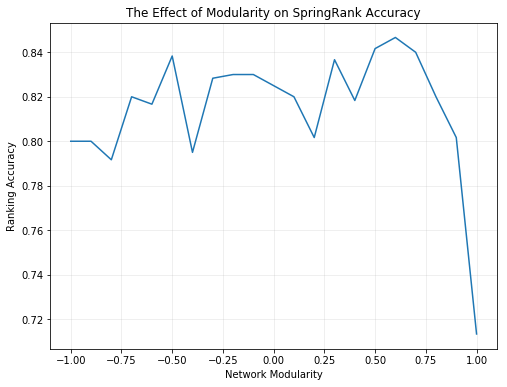

In [209]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.grid(alpha=0.25)
ax.plot(modularities, accuracies)
ax.set_xlabel("Network Modularity")
ax.set_ylabel("Ranking Accuracy")
ax.set_title("The Effect of Modularity on SpringRank Accuracy")